In [169]:
import cv2
import numpy as np
from commonfunctions import *
import imutils

In [170]:
def unsharp_mask(image, sigma=1.0, strength=1.5):
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Subtract the blurred image from the original
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

2.6440677966101696


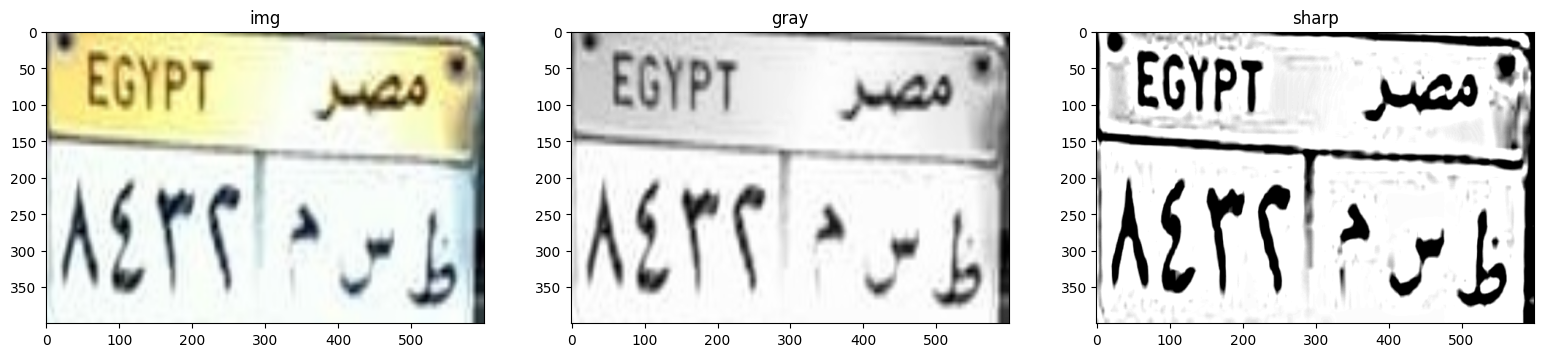

In [171]:
img = cv2.imread('Results3/0005.jpg', cv2.IMREAD_COLOR)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
image_copy = gray.copy()

img_threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

img_threshold = cv2.erode(img_threshold, np.ones((6, 6), np.uint8), iterations=1)
img_threshold = cv2.dilate(img_threshold, np.ones((1, 20), np.uint8), iterations=1)

contours, _ = cv2.findContours(img_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(max_contour)

aspect_ratio = w / h
print(aspect_ratio)
if 2.2 < aspect_ratio < 5:
    mask = np.zeros_like(image_copy)
    cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)
    masked_image = cv2.bitwise_and(image_copy, mask)
else:
    masked_image = image_copy
    print("No colored part detected. The whole image will be used.")

img = cv2.resize(img, (600, 400))
gray = cv2.resize(gray, (600, 400))
masked_image = cv2.resize(masked_image, (600, 400))

# gray = cv2.equalizeHist(gray)
# gray = cv2.GaussianBlur(gray, (5, 5), 10)
# gray = np.where(gray < 180, np.min(gray), gray)
sharp = unsharp_mask(masked_image,10,5)
show_images([img,gray,sharp], ['img','gray','sharp'])


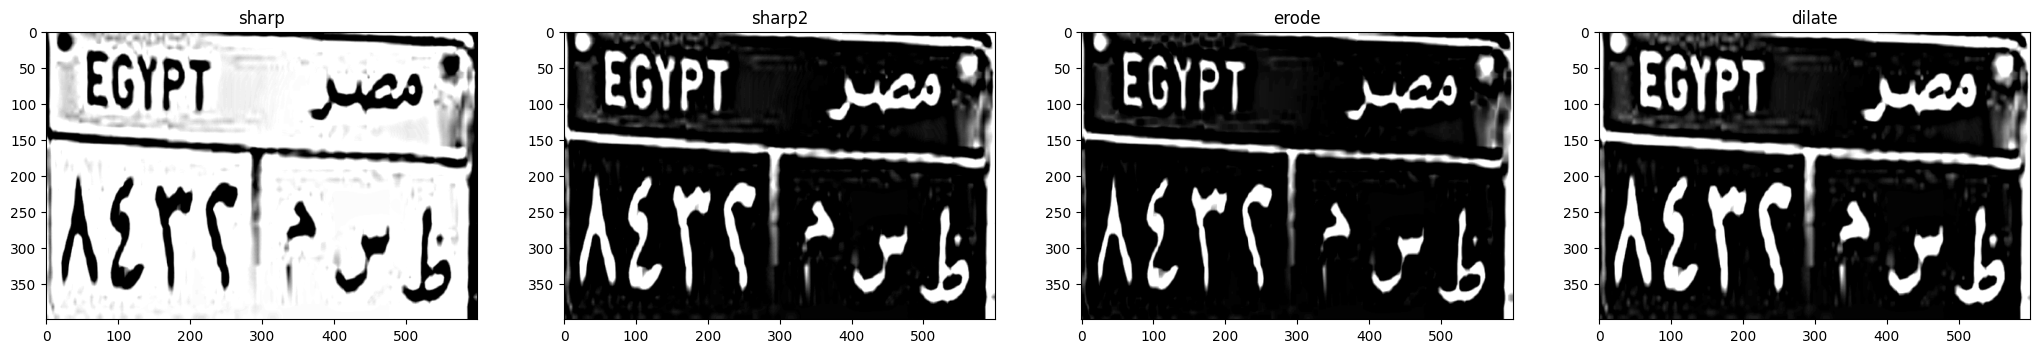

In [172]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 4))
sharp2 = cv2.bitwise_not(sharp)
erode = cv2.erode(sharp, rectKernel, iterations=1)
dilate = cv2.dilate(erode,(3,12), iterations=1)

#max filter
dilate = cv2.bitwise_not(dilate)
erode = cv2.erode(dilate, None, iterations=2)
show_images([sharp,sharp2,erode, dilate], ["sharp","sharp2","erode", "dilate"])

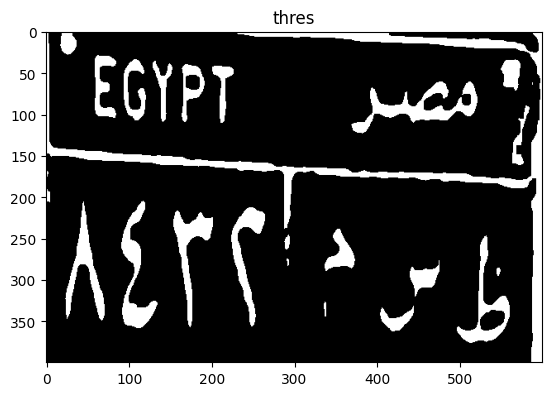

In [173]:
thresh = cv2.threshold(erode, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

show_images([thresh], ["thres"])

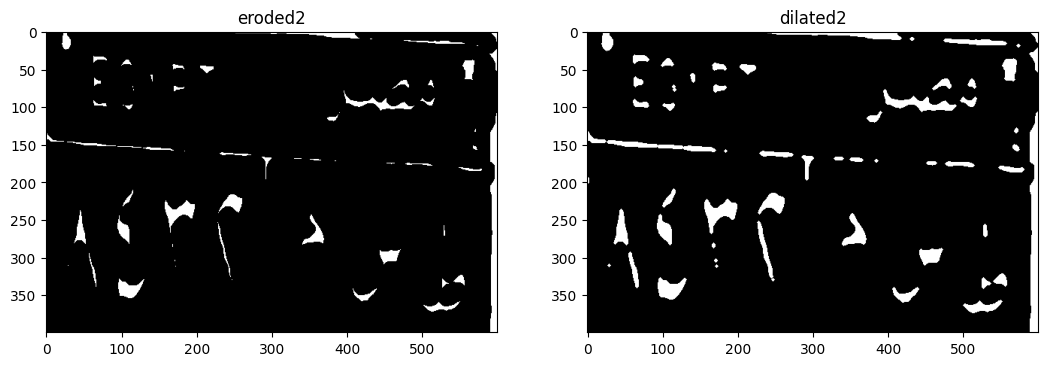

In [174]:
kernel_data = np.array([[0, 0, 1, 0, 0],
                        [0, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1],
                        [0, 1, 1, 1, 0],
                        [0, 0, 1, 0, 0]], dtype=np.uint8)
eroded2 = cv2.erode(thresh, kernel_data, iterations=2)
dilated2 = cv2.dilate(eroded2, kernel_data, iterations=1)
show_images([eroded2, dilated2], ["eroded2", "dilated2"])

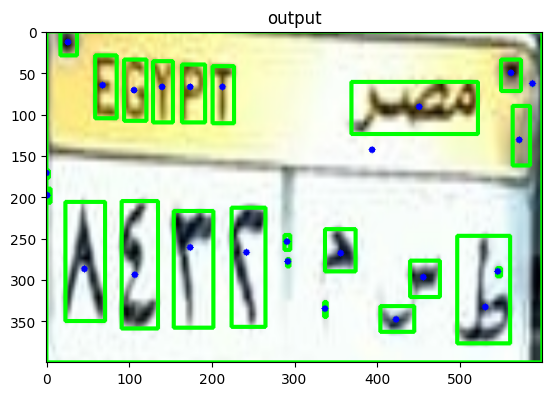

In [175]:
# get connected components and their stats
connectedComponents = cv2.connectedComponentsWithStats(
            thresh, 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = connectedComponents
output = img.copy()

for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
show_images([output], ["output"])

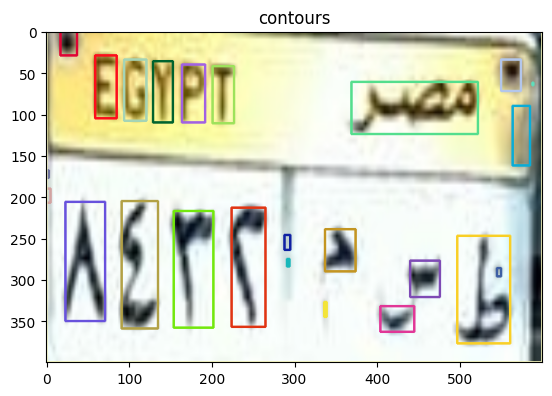

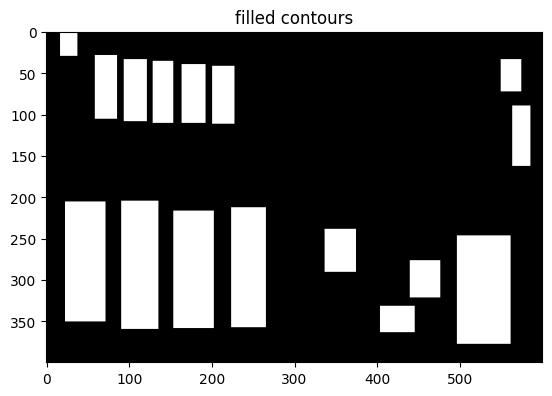

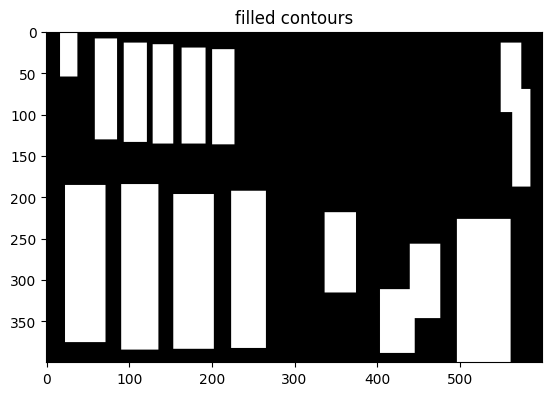

0.553030303030303 9636
0.37572254335260113 11245
0.3917525773195876 3686
0.2620320855614973 9163
0.22105263157894736 7980
0.2578947368421053 9310
0.225 9000
0.23478260869565218 3105
0.25 3364
0.20833333333333334 3000
0.20689655172413793 6264
0.23333333333333334 3360
0.22131147540983606 3294
0.38181818181818183 1155


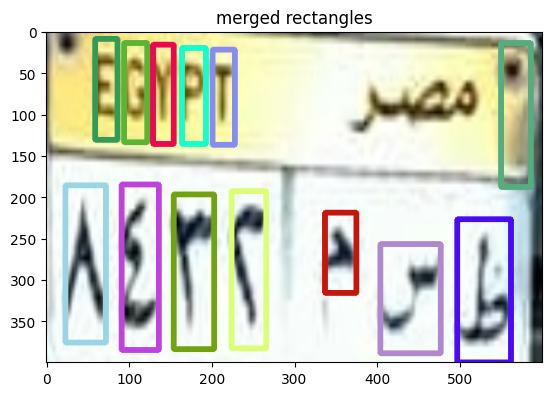

In [176]:
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#use 8 connectivity
cnts = imutils.grab_contours(cnts)
img_copy = img.copy()

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    # random color
    color = np.random.randint(0, 255, size=(3,)).tolist()
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 2)
show_images([img_copy], ['contours'])
    
img_filled = np.zeros_like(img)
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    aspect_ratio = w/h
    area = w*h
    if 0 < aspect_ratio < 1.4 and 500 < area < 50000:
        cv2.rectangle(img_filled, (x,y), (x+w,y+h), (255,255,255), thickness=cv2.FILLED)
show_images([img_filled], ['filled contours'])
img_filled = cv2.morphologyEx(img_filled, cv2.MORPH_DILATE,
                              cv2.getStructuringElement(cv2.MORPH_RECT, (1,10)),iterations=5)
img_filled = cv2.cvtColor(img_filled, cv2.COLOR_BGR2GRAY)
show_images([img_filled], ['filled contours'])

# find contours of filled image
cnts2 = cv2.findContours(img_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts2 = imutils.grab_contours(cnts2)
rectangles = []
for c in cnts2:
    (x, y, w, h) = cv2.boundingRect(c)
    rectangles.append((x,y,w,h))

img_copy = img.copy()
image_area = img.shape[0]*img.shape[1]
img_width = img.shape[1]
final_rectangles = []
for r in rectangles:
    if r is not None:
        (x, y, w, h) = r
        # random color
        aspect_ratio = w/h
        area = w*h
        print(aspect_ratio,area)
        if w < 0.6*h and 1500 < area < image_area/5 and  img_width/50< w:
            final_rectangles.append(r)
            color = np.random.randint(0, 255, size=(3,)).tolist()
            cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 5)
show_images([img_copy], ['merged rectangles'])

In [177]:
import os
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage import feature

#joblib is used to save the model
import joblib

In [178]:
def train_knn_model(data_set_path):
    # read images
    x_train = []
    y_train = []
    for dir in os.listdir(data_set_path):
        
        #label is directory name
        label = dir
        for file in os.listdir(os.path.join(data_set_path,dir)):
            if file.endswith('.png'):
                char_path = os.path.join(data_set_path,dir,file)
                # check if file exists
                if not os.path.isfile(char_path):
                    continue
                try:
                    img = io.imread(char_path)
                except:
                    continue
                if len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (20, 50))
                
                # extract hog features
                hog_img = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
                # hog_img = img.flatten()/255
                x_train.append(hog_img)
                y_train.append(label)
       
    data_set = np.array(x_train)
    labels = np.array(y_train)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(data_set, labels, test_size=0.2, random_state=1)
    
    # train model
    model = neighbors.KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)
    
    # test model
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    
    
    return model
    

In [179]:
def compute_threshold(data_set_path,knn_model):
    # read images
    x_train = []
    y_train = []
    for dir in os.listdir(data_set_path):
        #label is directory name
        label = dir
        for file in os.listdir(os.path.join(data_set_path,dir)):
                if file.endswith('.png'):
                    char_path = os.path.join(data_set_path,dir,file)
                    # check if file exists
                    if not os.path.isfile(char_path):
                        continue
                    try:
                        img = io.imread(char_path)
                    except:
                        continue
                    if len(img.shape) == 3:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (20, 50))
                    
                    #extract hog features
                    hog_img = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                                        cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
                    x_train.append(hog_img)
                    y_train.append(label)
       
    data_set = np.array(x_train)
    labels = np.array(y_train)
    
    distances, _ = knn_model.kneighbors(data_set)
    
    threshold = np.mean(distances) + 2*np.std(distances)
    
    return threshold

In [180]:
# model = train_knn_model('Chars_DataSet')
# joblib.dump(model, 'model_1.pkl')

In [181]:
knn_model = joblib.load('model_1.pkl')

In [182]:
# model_threshold = compute_threshold('Chars_DataSet',knn_model)

In [183]:
# print(model_threshold)
model_threshold = 1.5

13
550
1.5454349010566062
497
0.9108440170517416
1.5
0.9378572263599275
['ط']


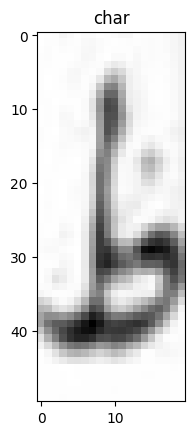

404
1.2509375446560005
1.5
1.2892610672002776
['س']


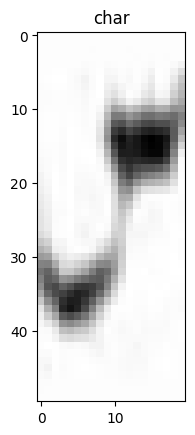

337
1.7075704007291082
224
1.0187709320697425
1.5
1.05898576317089
['٢']


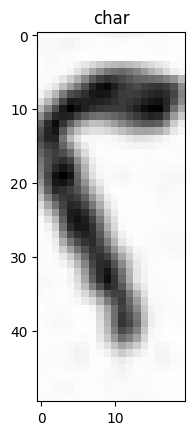

201
1.3294002067364536
1.5
1.3875549743470312
['أ']


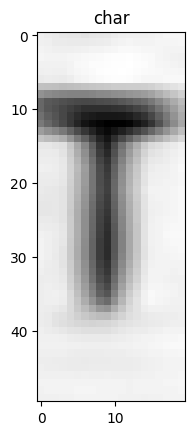

164
1.7842367694992358
154
0.8907133371645024
1.5
0.9614466329011476
['٣']


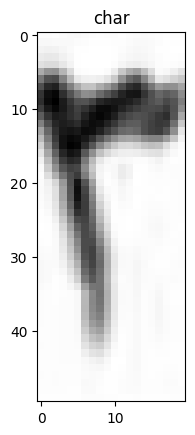

129
1.5369965253594742
94
1.5968608933301154
91
1.164692151692634
1.5
1.1777283612127214
['٤']


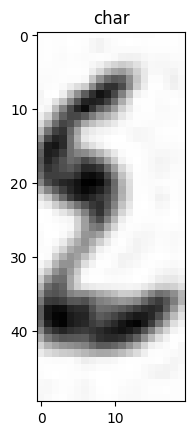

59
1.807280001692327
23
0.8609574196705275
1.5
0.887912052508477
['٨']


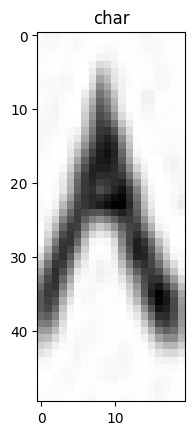

طس٢أ٣٤٨


In [184]:
final_rectangles = sorted(final_rectangles, key=lambda x: -x[0])
license_plate = ''
print(len(final_rectangles))
for rectangle in final_rectangles:
    x, y, w, h = rectangle
    char_img = img[y:y+h, x:x+w]
    char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
    char_img = cv2.resize(char_img, (20, 50))
    #adaptive thresholding
    hog_img = feature.hog(char_img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

    char = knn_model.predict([hog_img])
    print(x)
    distances, _ = knn_model.kneighbors([hog_img])
    nearest_distance = distances[0][0]
    print(nearest_distance)
    if nearest_distance > model_threshold:
        continue
    print(model_threshold)
    print(np.mean(distances))
    print(char)
    license_plate += char[0]
    show_images([char_img], ['char'])
    
#reverse license plate
print(license_plate)